# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [9]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [10]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

630

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [11]:
recordCount, setCount = 0, 0

url = "http://api.openweathermap.org/data/2.5/weather?APPID=" + weather_api_key 
print('------------------------')
print('Beginning Data Retrieval')
print('------------------------')

for city in cities:
    query = f"{url}&q={city}"
    response = requests.get(query).json()

    if recordCount < 50:
        recordCount += 1
    else:
        setCount += 1
        recordCount = 0
    
    print(f"Processing record {recordCount} of set {setCount} | {city}")

print('-------------------------')
print('Data Retrieval Complete')
print('-------------------------')

------------------------
Beginning Data Retrieval
------------------------
Processing record 1 of set 0 | ushuaia
Processing record 2 of set 0 | rikitea
Processing record 3 of set 0 | new norfolk
Processing record 4 of set 0 | fortuna
Processing record 5 of set 0 | port elizabeth
Processing record 6 of set 0 | sosnovo-ozerskoye
Processing record 7 of set 0 | barbar
Processing record 8 of set 0 | mataura
Processing record 9 of set 0 | punta arenas
Processing record 10 of set 0 | mentok
Processing record 11 of set 0 | hilo
Processing record 12 of set 0 | bluff
Processing record 13 of set 0 | abu samrah
Processing record 14 of set 0 | honningsvag
Processing record 15 of set 0 | attawapiskat
Processing record 16 of set 0 | vaini
Processing record 17 of set 0 | tarhunah
Processing record 18 of set 0 | ngunguru
Processing record 19 of set 0 | peniche
Processing record 20 of set 0 | jamestown
Processing record 21 of set 0 | hermanus
Processing record 22 of set 0 | laguna
Processing record 23 

Processing record 44 of set 3 | salvador
Processing record 45 of set 3 | sitka
Processing record 46 of set 3 | saint george
Processing record 47 of set 3 | tasiilaq
Processing record 48 of set 3 | veraval
Processing record 49 of set 3 | tokur
Processing record 50 of set 3 | druzhba
Processing record 0 of set 4 | folldal
Processing record 1 of set 4 | meulaboh
Processing record 2 of set 4 | belushya guba
Processing record 3 of set 4 | olinda
Processing record 4 of set 4 | inhambane
Processing record 5 of set 4 | mena
Processing record 6 of set 4 | pangody
Processing record 7 of set 4 | rocha
Processing record 8 of set 4 | raga
Processing record 9 of set 4 | santiago del estero
Processing record 10 of set 4 | mount isa
Processing record 11 of set 4 | piacabucu
Processing record 12 of set 4 | rawson
Processing record 13 of set 4 | la rioja
Processing record 14 of set 4 | ganzhou
Processing record 15 of set 4 | champerico
Processing record 16 of set 4 | mys shmidta
Processing record 17 of 

Processing record 40 of set 7 | todos santos
Processing record 41 of set 7 | lazaro cardenas
Processing record 42 of set 7 | narsaq
Processing record 43 of set 7 | chipinge
Processing record 44 of set 7 | muros
Processing record 45 of set 7 | yian
Processing record 46 of set 7 | varnavino
Processing record 47 of set 7 | palmer
Processing record 48 of set 7 | kieta
Processing record 49 of set 7 | suez
Processing record 50 of set 7 | bouar
Processing record 0 of set 8 | nizwa
Processing record 1 of set 8 | lalmanir hat
Processing record 2 of set 8 | sisimiut
Processing record 3 of set 8 | radis
Processing record 4 of set 8 | cedartown
Processing record 5 of set 8 | havoysund
Processing record 6 of set 8 | tromso
Processing record 7 of set 8 | college
Processing record 8 of set 8 | kupang
Processing record 9 of set 8 | krasnyy kholm
Processing record 10 of set 8 | avera
Processing record 11 of set 8 | boyolangu
Processing record 12 of set 8 | kununurra
Processing record 13 of set 8 | darn

Processing record 33 of set 11 | fare
Processing record 34 of set 11 | yulara
Processing record 35 of set 11 | namibe
Processing record 36 of set 11 | huarmey
Processing record 37 of set 11 | cuamba
Processing record 38 of set 11 | meadow lake
Processing record 39 of set 11 | sasaram
Processing record 40 of set 11 | carutapera
Processing record 41 of set 11 | karratha
Processing record 42 of set 11 | batagay-alyta
Processing record 43 of set 11 | kenora
Processing record 44 of set 11 | sinnamary
Processing record 45 of set 11 | anupgarh
Processing record 46 of set 11 | amahai
Processing record 47 of set 11 | havre-saint-pierre
Processing record 48 of set 11 | fort nelson
Processing record 49 of set 11 | toma
Processing record 50 of set 11 | bajo baudo
Processing record 0 of set 12 | sampit
Processing record 1 of set 12 | saint-junien
Processing record 2 of set 12 | katangli
Processing record 3 of set 12 | juba
Processing record 4 of set 12 | samarai
Processing record 5 of set 12 | oda


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

## Latitude vs. Temperature Plot

In [12]:
url = "http://api.openweathermap.org/data/2.5/weather?APPID=" + weather_api_key 

new_city = []
lat = []
lng = []
temp = []
humidity = []
cloudiness = []
wind = []
country = []
date = []

for city in cities:
    query = f"{url}&q={city}"
    response = requests.get(query).json()
    
    try:
        cloudiness.append(response['clouds']['all'])
        country.append(response['sys']['country'])
        date.append(response['dt'])
        humidity.append(response['main']['humidity'])
        temp.append(response['main']['temp_max'])
        lat.append(response['coord']['lat'])
        lng.append(response['coord']['lon'])
        wind.append(response['wind']['speed'])
        new_city.append(city)
    except:
        pass

weather_dict = {
    "City": new_city,
    "Lat": lat,
    "Lng": lng,
    "MaxTemp": temp,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind Speed": wind,
    "Country": country,
    "Date": date,
}

weather_data = pd.DataFrame(weather_dict)
weather_data.to_csv(output_data_file)
weather_data.head()

,City,Lat,Lng,MaxTemp,Humidity,Cloudiness,Wind Speed,Country,Date
0,ushuaia,-54.8000,-68.3000,276.96,81,20,2.57,AR,1650173169
1,rikitea,-23.1203,-134.9692,299.09,67,17,6.57,PF,1650173229
2,new norfolk,-42.7826,147.0587,299.22,34,100,2.24,AU,1650173230
3,fortuna,40.5982,-124.1573,279.07,88,0,2.06,US,1650173230
4,port elizabeth,-33.9180,25.5701,289.44,95,20,4.12,ZA,1650173231


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [13]:
#  Get the indices of cities that have humidity over 100%.
weather_data[weather_data['Humidity'] > 100]

,City,Lat,Lng,MaxTemp,Humidity,Cloudiness,Wind Speed,Country,Date


In [6]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [14]:
import datetime
date = datetime.datetime.fromtimestamp(int(weather_data['Date'][0])).strftime('%m/%d/%Y')

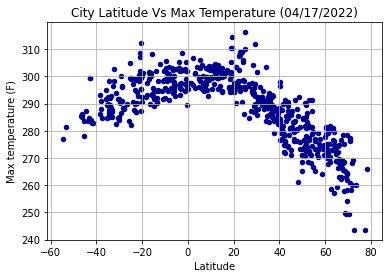

<Figure size 432x288 with 0 Axes>

In [15]:
weather_data.plot(kind='scatter', x='Lat', y='MaxTemp', c='DarkBlue')
plt.title(f'City Latitude Vs Max Temperature ({date})')
plt.xlabel('Latitude')
plt.ylabel('Max temperature (F)')
plt.grid()
plt.show()
plt.savefig("../Images/LatitudeVsTemperature.png")

## Latitude vs. Humidity Plot

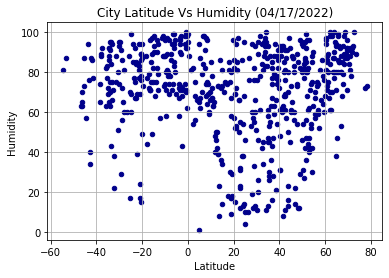

In [16]:
weather_data.plot(kind='scatter', x='Lat', y='Humidity', c='DarkBlue')
plt.title(f'City Latitude Vs Humidity ({date})')
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.grid()
plt.savefig("../Images/LatitudeVsHumidity.png")

## Latitude vs. Cloudiness Plot

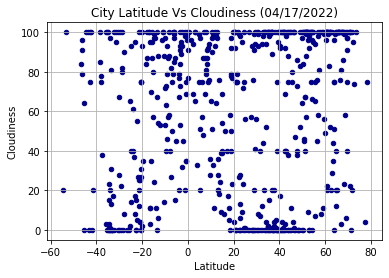

In [17]:
weather_data.plot(kind='scatter', x='Lat', y='Cloudiness', c='DarkBlue')
plt.title(f'City Latitude Vs Cloudiness ({date})')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.grid()
plt.savefig("../Images/LatitudeVsCloudiness.png")

## Latitude vs. Wind Speed Plot

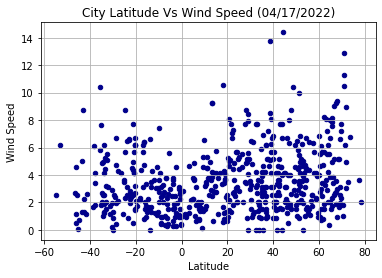

In [18]:
weather_data.plot(kind='scatter', x='Lat', y='Wind Speed', c='DarkBlue')
plt.title(f'City Latitude Vs Wind Speed ({date})')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.grid()
plt.savefig("../Images/LatitudeVsWindSpeed.png")

## Linear Regression

In [19]:
# Divide Northern Hemisphere and Southern Hemisphere
northern_hemisphere = weather_data[weather_data['Lat'] >= 0]
southern_hemisphere = weather_data[weather_data['Lat'] < 0]

In [20]:
def makeLinRegression(df, x_Col, y_Col):
    (regr_slope, regr_intercept, regr_r_val, _, _) = linregress(df[x_Col], df[y_Col])
    regr_line_x = np.array([a for a in range(int(min(df[x_Col].values)), int(max(df[x_Col].values)+1))])
    regr_line_y = regr_slope * regr_line_x + regr_intercept
    line_eq = "y = " + str(round(regr_slope,2)) + "x + " + str(round(regr_intercept,2))

    df_axes = df.plot(kind="scatter", x=x_Col, y=y_Col, 
                    title=f"{y_Col} vs. {x_Col} ({date})")

    df_axes.plot(regr_line_x, regr_line_y, 'r')
    
    plt.annotate(line_eq, (min(regr_line_x)+10, min(regr_line_y)+10), fontsize=12, color="red")

    print(f"The r-value is: {regr_r_val:.2f}")
                  
    return df_axes

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.87


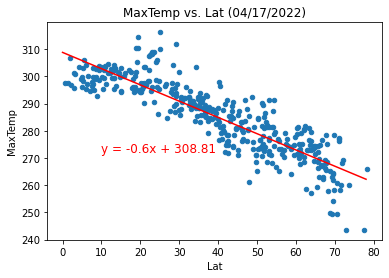

In [21]:
n_temp_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "MaxTemp")
n_temp_lat_axes.get_figure().savefig("../Images/MaxTempVSLatitudeNorthernHemisphere.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.64


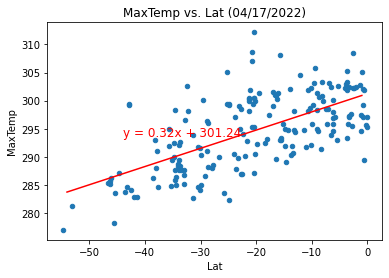

In [22]:
s_temp_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "MaxTemp")
s_temp_lat_axes.get_figure().savefig("../Images/MaxTempVSLatitudeSouthernHemisphere.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.28


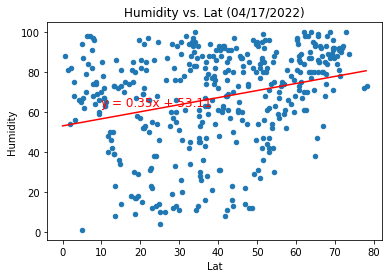

In [23]:
n_humidity_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Humidity")
n_humidity_lat_axes.get_figure().savefig("../Images/HumidityVSLatitudeNorthernHemisphere.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.21


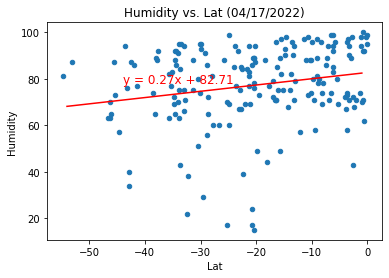

In [24]:
s_humidity_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Humidity")
s_humidity_lat_axes.get_figure().savefig("../Images/HumidityvSLatitudeSouthernHemisphere.png")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.13


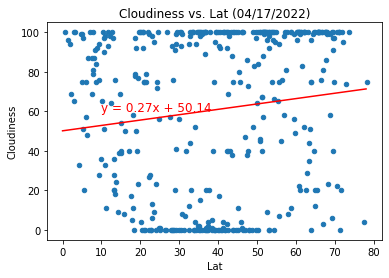

In [25]:
n_cloudiness_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Cloudiness")
n_cloudiness_lat_axes.get_figure().savefig("../Images/CloudinessVSLatitudeNorthernHemisphere.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.24


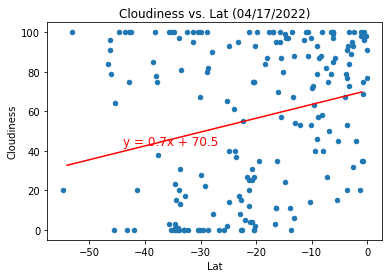

In [26]:
s_cloudiness_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Cloudiness")
s_cloudiness_lat_axes.get_figure().savefig("../Images/CloudinessVSLatitudeSouthernHemisphere.png")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.18


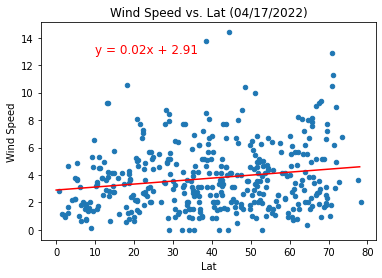

In [27]:
n_wind_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Wind Speed")
n_wind_lat_axes.get_figure().savefig("../Images/WindSpeedVSLatitudeNorthernHemisphere.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.20


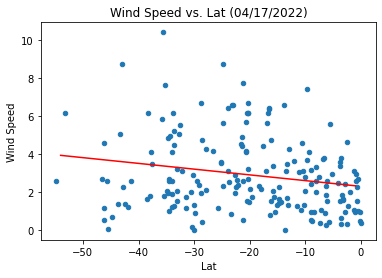

In [28]:
s_wind_lat_axes=makeLinRegression(southern_hemisphere, "Lat", "Wind Speed")
s_wind_lat_axes.get_figure().savefig("../Images/WindSpeedVSLatitudeSouthernHemisphere.png")